In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch, torchaudio
import IPython.display as display

from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer

/Users/yingli/opt/anaconda3/envs/torch1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc

from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import PCA


* to do emotion recognition, it is best to train a specific model
* this page has good examples https://huggingface.co/docs/transformers/model_doc/wav2vec2
* a good example: https://colab.research.google.com/github/m3hrdadfi/soxan/blob/main/notebooks/Emotion_recognition_in_Greek_speech_using_Wav2Vec2.ipynb


In [3]:
audio, rate = librosa.load("/Users/yingli/Development/AppliedDataScience/voice_clips_wav/common_voice_en_1716.wav", sr=16000)
audio, rate = librosa.load("/Users/yingli/Development/AppliedDataScience/applieddatascience/sample_code/John_1_1_YingLi.wav", sr=16000)

In [4]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

audio, rate = librosa.load("/Users/yingli/Development/AppliedDataScience/applieddatascience/sample_code/John_1_1_YingLi.wav", sr=16000)

input_values = processor(audio, sampling_rate = 16000, return_tensors = "pt").input_values
logits = model(input_values).logits
prediction = torch.argmax(logits, dim = -1)
transcription = processor.batch_decode(prediction)[0]

print(transcription)


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


IN THE BEGINNING WAS THE WORD AND THE WORD WAS WITH GOD AND THE WORD WAS GOD


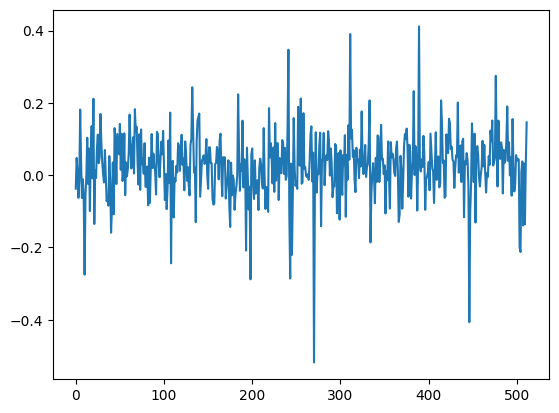

In [5]:
x = model.wav2vec2(input_values)
plt.plot(x.extract_features.mean(axis=1)[0,:].detach().numpy())

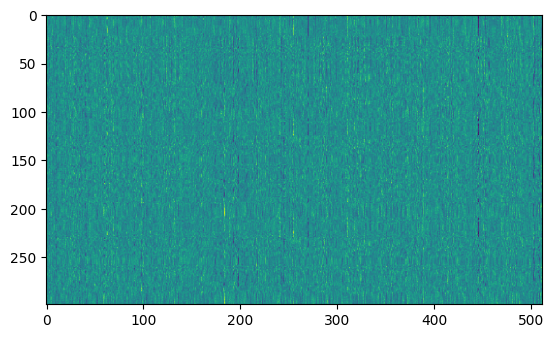

In [6]:
plt.imshow(x.extract_features[0,:,:].detach().numpy())

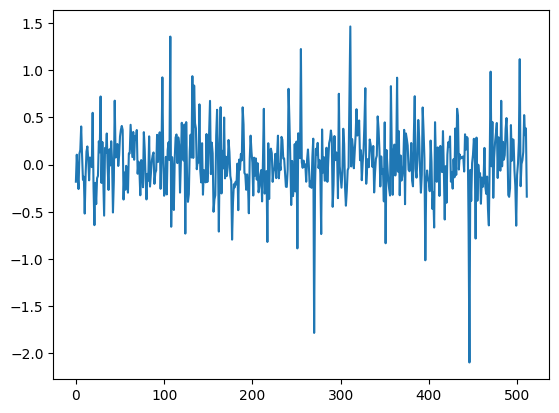

In [7]:
plt.plot(x.extract_features[0,2,:].detach().numpy())

In [8]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

raw_audio, rate = torchaudio.load("/Users/yingli/Development/AppliedDataScience/applieddatascience/sample_code/John_1_1_YingLi.wav")
audio = torchaudio.functional.resample(raw_audio, orig_freq = rate, new_freq=16000)

input_values = processor(audio[0,:], sampling_rate = 16000, return_tensors = "pt").input_values
logits = model(input_values).logits
prediction = torch.argmax(logits, dim = -1)
transcription = processor.decode(prediction[0])

print(transcription)


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


IN THE BEGINNING WAS THE WORD AND THE WORD WAS WITH GOD AND THE WORD WAS GOD


In [9]:
# !pip install transformers
# !pip install datasets
import soundfile as sf
import torch
from datasets import load_dataset
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# load pretrained model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

librispeech_samples_ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")


# load audio
audio_input, sample_rate = sf.read(librispeech_samples_ds[0]["file"])

# pad input values and return pt tensor
input_values = processor(audio_input, sampling_rate=sample_rate, return_tensors="pt").input_values

# INFERENCE

# retrieve logits & take argmax
logits = model(input_values).logits
predicted_ids = torch.argmax(logits, dim=-1)

# transcribe
transcription = processor.decode(predicted_ids[0])

# FINE-TUNE

target_transcription = "A MAN SAID TO THE UNIVERSE I EXIST"

# encode labels
with processor.as_target_processor():
  labels = processor(target_transcription, return_tensors="pt").input_ids

# compute loss by passing labels
loss = model(input_values, labels=labels).loss
loss.backward()
print(transcription)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Found cached dataset librispeech_asr_dummy (/Users/yingli/.cache/huggingface/datasets/patrickvonplaten___librispeech_asr_dummy/clean/2.1.0/f2c70a4d03ab4410954901bde48c54b85ca1b7f9bf7d616e7e2a72b5ee6ddbfc)
/Users/yingli/opt/anaconda3/envs/torch1/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


A MAN SAID TO THE UNIVERSE SIR I EXIST


In [10]:
from datasets import load_dataset
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# load pretrained model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

audio, rate = librosa.load("/Users/yingli/Development/AppliedDataScience/applieddatascience/sample_code/John_1_1_YingLi.wav", sr=16000)




# pad input values and return pt tensor
input_values = processor(audio, sampling_rate=16000, return_tensors="pt").input_values

# INFERENCE

# retrieve logits & take argmax
logits = model(input_values).logits
predicted_ids = torch.argmax(logits, dim=-1)

# transcribe
transcription = processor.decode(predicted_ids[0])

# FINE-TUNE

target_transcription = "A MAN SAID TO THE UNIVERSE I EXIST"

# encode labels
with processor.as_target_processor():
  labels = processor(target_transcription, return_tensors="pt").input_ids

# compute loss by passing labels
loss = model(input_values, labels=labels).loss
loss.backward()

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
loss


tensor(693.7931, grad_fn=<SumBackward0>)

In [12]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torchaudio

# load model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

audio, rate = librosa.load("/Users/yingli/Development/AppliedDataScience/applieddatascience/sample_code/John_1_1_YingLi.wav", sr=16000)

# audio file is decoded on the fly
#array, fs = torchaudio.load("/data/A-VB/audio/wav/00001.wav")
#input = processor(array.squeeze(), sampling_rate=fs, return_tensors="pt")

input = processor(audio, sampling_rate=16000, return_tensors="pt")


# apply the model to the input array from wav
with torch.no_grad():
    outputs = model(**input)

# extract last hidden state, compute average, convert to numpy
last_hidden_states = outputs.last_hidden_state.squeeze().mean(axis=0).numpy()

# change to list to print
print(f"Hidden state shape: {last_hidden_states.shape}")
# Hidden state shape: (768,)


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Hidden state shape: (768,)


In [13]:
last_hidden_states.shape

(768,)

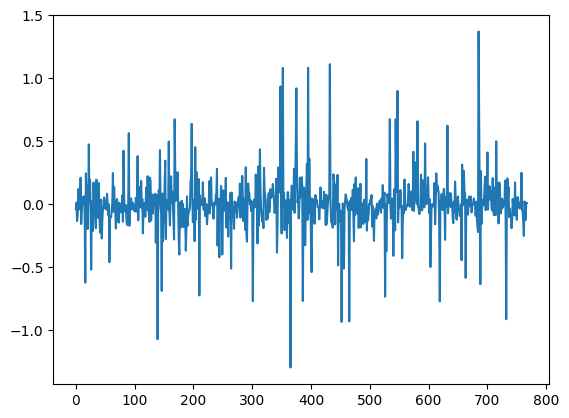

In [15]:
plt.plot(last_hidden_states)

In [16]:
import torch
from transformers import AutoProcessor, AutoModelForAudioClassification, Wav2Vec2FeatureExtractor
import numpy as np
#from pydub import AudioSegment

# https://github.com/ehcalabres/EMOVoice
# the preprocessor was derived from https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-english
# processor1 = AutoProcessor.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")
# ^^^ no preload model available for this model (above), but the `feature_extractor` works in place
model1 = AutoModelForAudioClassification.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")


/Users/yingli/opt/anaconda3/envs/torch1/lib/python3.10/site-packages/transformers/configuration_utils.py:379: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.output.weight', 'classifier.output.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequen

In [17]:
audio, rate = librosa.load("/Users/yingli/Development/AppliedDataScience/applieddatascience/sample_code/John_1_1_YingLi.wav", sr=16000)
#audio, rate = librosa.load("/Users/yingli/Development/AppliedDataScience/ESD/0011/Angry/evaluation/0011_000352.wav", sr=16000)
#audio, rate = librosa.load("/Users/yingli/Development/AppliedDataScience/emotion_sound/male_sorbing.wav", sr=16000)
#raw_audio, rate = torchaudio.load("/Users/yingli/Development/AppliedDataScience/RAVDESS/Actor_01/03-01-05-01-01-02-01.wav")
#audio = torchaudio.functional.resample(raw_audio, orig_freq = rate, new_freq=16000)

input = feature_extractor(
        raw_speech=audio,
        sampling_rate=16000,
        padding=True,
        return_tensors="pt")

result = model1.forward(input.input_values.float())
    # making sense of the result 
id2label = {
        "0": "angry",
        "1": "calm",
        "2": "disgust",
        "3": "fearful",
        "4": "happy",
        "5": "neutral",
        "6": "sad",
        "7": "surprised"
    }
interp = dict(zip(id2label.values(), list(round(float(i),4) for i in result[0][0])))
interp

{'angry': -0.0479,
 'calm': -0.0492,
 'disgust': 0.0115,
 'fearful': 0.0034,
 'happy': -0.0164,
 'neutral': 0.0504,
 'sad': -0.0397,
 'surprised': 0.0189}

In [18]:
result.logits

tensor([[-0.0479, -0.0492,  0.0115,  0.0034, -0.0164,  0.0504, -0.0397,  0.0189]],
       grad_fn=<AddmmBackward0>)

In [19]:
display.Audio(input.input_values.squeeze(),rate = 16000)

In [20]:
result

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0479, -0.0492,  0.0115,  0.0034, -0.0164,  0.0504, -0.0397,  0.0189]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [21]:
import torch
from transformers import AutoProcessor, AutoModelForAudioClassification, Wav2Vec2FeatureExtractor
import numpy as np

def predict_emotion(audio_file):
    audio, _ = librosa.load(audio_file, sr = 16000)
    model1 = AutoModelForAudioClassification.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")
    
    input = feature_extractor(
        raw_speech=audio,
        sampling_rate=16000,
        padding=True,
        return_tensors="pt")

    result = model1.forward(input.input_values.float())
    # making sense of the result 
    id2label = {
        "0": "angry",
        "1": "calm",
        "2": "disgust",
        "3": "fearful",
        "4": "happy",
        "5": "neutral",
        "6": "sad",
        "7": "surprised"
    }
    interp = dict(zip(id2label.values(), list(round(float(i),4) for i in result[0][0])))
    return interp

In [22]:
predict_emotion(audio_file = "/Users/yingli/Development/AppliedDataScience/RAVDESS" +'/Actor_01/03-01-05-01-01-02-01.wav')

Some weights of the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.output.weight', 'classifier.output.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition and are newly initialized: ['projector.bias', 'classifier.bias', 'pro

{'angry': -0.0842,
 'calm': 0.0435,
 'disgust': 0.0069,
 'fearful': -0.1635,
 'happy': 0.0126,
 'neutral': -0.0039,
 'sad': -0.1245,
 'surprised': 0.0761}

### using scikit-learn to train an emotion classifier, based on RAVDESS data

In [23]:
voice_features = pd.read_csv("RAVDESS_voice_features_20230428.csv")


In [24]:
col_list_mfcc = ['mfcc_00', 'mfcc_01', 'mfcc_02', 'mfcc_03', 'mfcc_04', 'mfcc_05',
       'mfcc_06', 'mfcc_07', 'mfcc_08', 'mfcc_09', 'mfcc_10', 'mfcc_11',
       'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17',
       'mfcc_18', 'mfcc_19', 'mfcc_20', 'mfcc_21', 'mfcc_22', 'mfcc_23',
       'mfcc_24']
col_list_f0 = ['f0_mean', 'f0_std','f0_var','f0_min','f0_max','f0_skew', 'f0_kurtosis']
col_list_zcr = ['zcr_mean','zcr_std','zcr_var','zcr_min','zcr_max','zcr_skew','zcr_kurtosis']

              precision    recall  f1-score   support

       angry     0.8364    0.7188    0.7731        64
        calm     0.6977    0.4615    0.5556        65
     disgust     0.5692    0.6066    0.5873        61
     fearful     0.5968    0.5781    0.5873        64
       happy     0.5735    0.5909    0.5821        66
     neutral     0.2703    0.3571    0.3077        28
         sad     0.4835    0.7097    0.5752        62
   surprised     0.7818    0.6515    0.7107        66

    accuracy                         0.6008       476
   macro avg     0.6011    0.5843    0.5849       476
weighted avg     0.6277    0.6008    0.6063       476



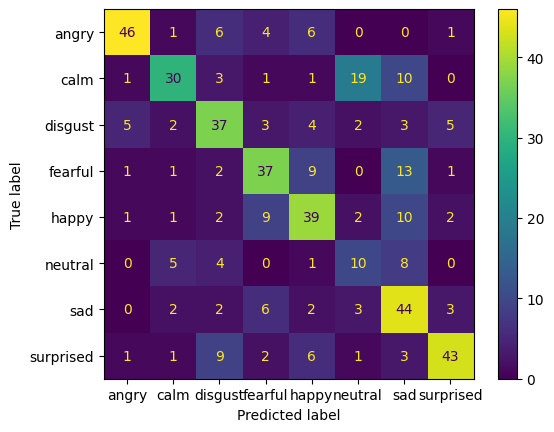

In [25]:
X = voice_features[col_list_f0 + col_list_mfcc+col_list_zcr]
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)
y = voice_features['emotion']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)

mlp_clf = MLPClassifier(random_state=1, learning_rate= "adaptive", 
                        max_iter=1000, hidden_layer_sizes=(500,200,200,100)).fit(X_train, y_train)
y_pred = mlp_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred, digits = 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

              precision    recall  f1-score   support

       angry     0.6667    0.7429    0.7027        35
        calm     0.7143    0.7692    0.7407        26
     disgust     0.8276    0.6667    0.7385        36
     fearful     0.6250    0.6897    0.6557        29
       happy     0.4643    0.4815    0.4727        27
     neutral     0.5556    0.5263    0.5405        19
         sad     0.6061    0.5714    0.5882        35
   surprised     0.7419    0.7419    0.7419        31

    accuracy                         0.6555       238
   macro avg     0.6502    0.6487    0.6476       238
weighted avg     0.6602    0.6555    0.6558       238



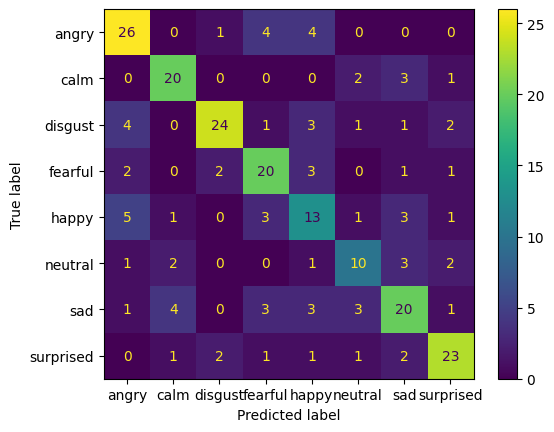

In [26]:
X = voice_features.query("gender == 'male'")[col_list_f0 + col_list_mfcc+col_list_zcr]
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)
y = voice_features.query("gender == 'male'")['emotion']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)

mlp_clf = MLPClassifier(random_state=1, learning_rate= "adaptive", 
                        max_iter=1000, hidden_layer_sizes=(300,200,200)).fit(X_train, y_train)
y_pred = mlp_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred, digits = 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

              precision    recall  f1-score   support

       angry     0.8077    0.7241    0.7636        29
        calm     0.7037    0.6129    0.6552        31
     disgust     0.7812    0.6944    0.7353        36
     fearful     0.7632    0.7838    0.7733        37
       happy     0.7429    0.7879    0.7647        33
     neutral     0.3333    0.3571    0.3448        14
         sad     0.5500    0.7586    0.6377        29
   surprised     0.8400    0.7241    0.7778        29

    accuracy                         0.7059       238
   macro avg     0.6902    0.6804    0.6816       238
weighted avg     0.7189    0.7059    0.7086       238



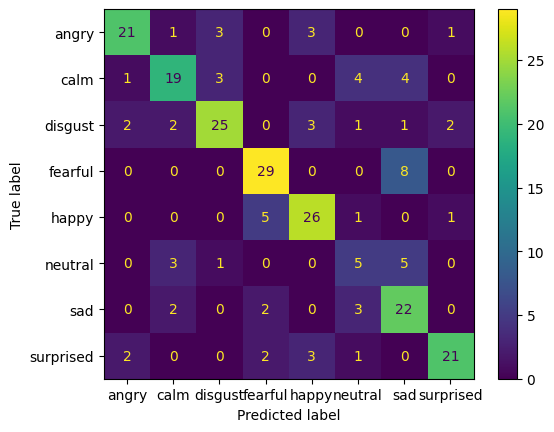

In [27]:
X = voice_features.query("gender == 'female'")[col_list_f0 + col_list_mfcc+col_list_zcr]
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)
y = voice_features.query("gender == 'female'")['emotion']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)

mlp_clf = MLPClassifier(random_state=1, learning_rate= "adaptive", 
                        max_iter=1000, hidden_layer_sizes=(300,200,200)).fit(X_train, y_train)
y_pred = mlp_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred, digits = 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)